In [1]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("train_model/data/bitcoin_2017_to_2023.csv")

df = df.dropna()
df = df.reset_index(drop=True)

df["timestamp"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

df = df.sort_values(by=["timestamp"])
# df = df.drop(columns=["timestamp"])
df = df.reset_index(drop=True)

df_len = len(df)
test_size = 0.2
cut_idx = int(df_len* (1 - test_size))
train, val = df.iloc[:cut_idx], df.iloc[cut_idx:]

numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume']

In [5]:

scaler = MinMaxScaler(feature_range=(-1, 1))
train = train.copy()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
val = val.copy()
val[numeric_cols] = scaler.transform(val[numeric_cols])

In [6]:
from tslearn.metrics import dtw
import numpy as np
from tqdm import tqdm
from heapq import heappop, heappush

window_size = 70
stride = 35
for index in range(0, len(train), stride):
    arr_data = train.iloc[index:index + window_size][numeric_cols].values

    top_k = []
    for target_index in tqdm(range(0, len(train), stride)):
        if index == target_index:
            continue
        
        arr_target = train.iloc[target_index:target_index + window_size][numeric_cols].values
        cost = dtw(arr_data, arr_target, global_constraint="sakoe_chiba", sakoe_chiba_radius=5)

        if len(top_k) < 5:
            heappush(top_k, (cost, arr_target))
        else:
            if cost < top_k[0][0]:
                heappush(top_k, (cost, arr_target))
                heappop(top_k)
        
    break

100%|██████████| 71452/71452 [00:51<00:00, 1388.99it/s]


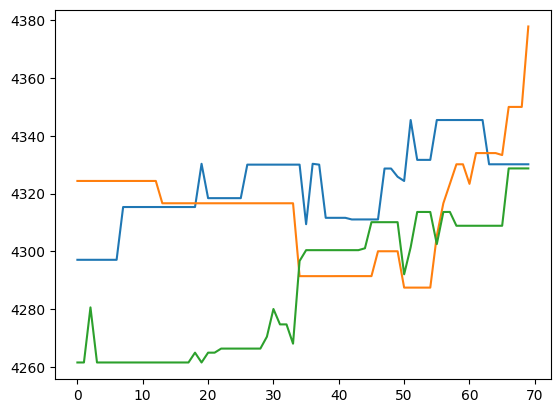

In [16]:
import matplotlib.pyplot as plt

plt.plot(top_k[0][1][:, 0], label="1")
plt.plot(top_k[1][1][:, 0], label="2")
plt.plot(top_k[2][1][:, 0], label="3")
plt.plot(top_k[3][1][:, 0], label="4")
plt.plot(top_k[4][1][:, 0], label="5")
plt.plot(arr_data[:, 0])